In [2]:
import scipy.io as sio
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

Using TensorFlow backend.


In [78]:
#loading data
DDataFile = './data/D_VLOS_channelVector_B32_U200000.mat'
DData = sio.loadmat(DDataFile)

LocationDataFile = './data/randLocationU200000VIP.mat'
locationData = sio.loadmat(LocationDataFile)


In [79]:
#preprocessing the data
D_data = DData['D']
location_data = np.transpose(locationData['location'])
location_data = location_data[:,:2]

D_data = np.transpose(np.concatenate((np.real(D_data),np.imag(D_data))))

print(D_data.shape,location_data.shape)
total, l = D_data.shape
total, d = location_data.shape

train_length = int(np.floor(total * 0.8))

impulses_train = D_data[:train_length, :]
location_train = location_data[:train_length,:]
print(total,train_length, impulses_train.shape, location_train.shape)

impulses_test = D_data[train_length:, :]
location_test = location_data[train_length:,:]

(200000, 64) (200000, 2)
200000 160000 (160000, 64) (160000, 2)



- ~~the two conv layers & three 1024 dense layers-> result is (0.14,170) mean=24, val_loss=509~~

- one conv layer but averagepooling & three 1024 dense layers-> result is (0.079,165.9) mean=23.9, val_loss=505
- ~~one conv layer but maxpooling & three 1024 dense layers -> (0.16,172) mean=24.04 val_loss=509.8~~
- ~~add batchNormalization and dropout ->result is very bad the val_loss did not decrease and val_loss is 8780, the distance is (0.4-268.4) mean is 116 ~~
- ~~only add drop out(0.2) -> result is not good~~
- ~~one conv layers and two 1024 dense layers ->(0.25-260) mean is 26.9~~
- change the conve layer from 1024 to 256 ->(0.01,167) , mean=24.06
- data 200k, (0.01,161) mean = 22.6, loss=466.8

In [80]:
#Build the model
model = keras.Sequential()

keras.layers.Conv2D(256, 3) 
keras.layers.AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)

model.add(Dense(1024, activation = 'relu')) 
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(1024, activation = 'relu'))

model.add(Dense(d, activation = 'linear'))  # None is different from 'linear'      ### the output layer

In [81]:
#Compilation
loss_func = 'mean_squared_error'   #   categorical_crossentropy(bad)   mean_squared_error
opt_func = keras.optimizers.Adam(lr=0.0001) #'Adam'  lr=0.2  #  RMSprop(overfiiting) sgd(overfitting)  Adadelta(overfitting)   Adam

model.compile(loss = loss_func, 
              optimizer = opt_func,
             metrics = ['mae'])

#best set: categorical_crossentropy  and sgd, but the loss and acc do not change....

In [82]:
#Train the model, iterating
early_stop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.1)
history = model.fit(impulses_train, location_train,
                    batch_size = 20, # 10,20
                    epochs = 200,
                    verbose = 2,
                    validation_split = 0.2 #0.2
                   )


Train on 128000 samples, validate on 32000 samples
Epoch 1/200
 - 378s - loss: 15257.5839 - mean_absolute_error: 78.9103 - val_loss: 986.9254 - val_mean_absolute_error: 23.5085
Epoch 2/200
 - 376s - loss: 726.7497 - mean_absolute_error: 20.0630 - val_loss: 606.0732 - val_mean_absolute_error: 18.4647
Epoch 3/200
 - 391s - loss: 530.9524 - mean_absolute_error: 17.1602 - val_loss: 528.8756 - val_mean_absolute_error: 17.0430
Epoch 4/200
 - 391s - loss: 464.8256 - mean_absolute_error: 15.9916 - val_loss: 474.3594 - val_mean_absolute_error: 16.0795
Epoch 5/200
 - 390s - loss: 428.6862 - mean_absolute_error: 15.3382 - val_loss: 440.1176 - val_mean_absolute_error: 15.4142
Epoch 6/200
 - 390s - loss: 407.9572 - mean_absolute_error: 14.9410 - val_loss: 423.0622 - val_mean_absolute_error: 14.9488
Epoch 7/200
 - 391s - loss: 390.6558 - mean_absolute_error: 14.5806 - val_loss: 446.4970 - val_mean_absolute_error: 15.5289
Epoch 8/200
 - 391s - loss: 378.1617 - mean_absolute_error: 14.3139 - val_loss:

Epoch 67/200
 - 373s - loss: 126.9503 - mean_absolute_error: 8.3716 - val_loss: 470.0362 - val_mean_absolute_error: 15.2656
Epoch 68/200
 - 373s - loss: 124.0200 - mean_absolute_error: 8.2984 - val_loss: 453.1971 - val_mean_absolute_error: 14.8251
Epoch 69/200
 - 374s - loss: 121.2014 - mean_absolute_error: 8.2018 - val_loss: 461.7878 - val_mean_absolute_error: 15.2019
Epoch 70/200
 - 374s - loss: 118.4585 - mean_absolute_error: 8.1172 - val_loss: 464.6483 - val_mean_absolute_error: 14.9748
Epoch 71/200
 - 374s - loss: 115.4109 - mean_absolute_error: 8.0174 - val_loss: 470.6359 - val_mean_absolute_error: 15.0901
Epoch 72/200
 - 375s - loss: 112.6795 - mean_absolute_error: 7.9139 - val_loss: 463.2583 - val_mean_absolute_error: 14.9883
Epoch 73/200
 - 382s - loss: 110.5009 - mean_absolute_error: 7.8508 - val_loss: 461.0039 - val_mean_absolute_error: 14.9548
Epoch 74/200
 - 375s - loss: 107.4918 - mean_absolute_error: 7.7559 - val_loss: 471.4256 - val_mean_absolute_error: 15.0469
Epoch 75

Epoch 134/200
 - 378s - loss: 38.1283 - mean_absolute_error: 4.6842 - val_loss: 479.6568 - val_mean_absolute_error: 15.0915
Epoch 135/200
 - 375s - loss: 37.7455 - mean_absolute_error: 4.6606 - val_loss: 493.0442 - val_mean_absolute_error: 15.3706
Epoch 136/200
 - 374s - loss: 37.2560 - mean_absolute_error: 4.6343 - val_loss: 479.7436 - val_mean_absolute_error: 15.0449
Epoch 137/200
 - 373s - loss: 36.3935 - mean_absolute_error: 4.5734 - val_loss: 470.4013 - val_mean_absolute_error: 14.8863
Epoch 138/200
 - 373s - loss: 36.1314 - mean_absolute_error: 4.5642 - val_loss: 472.2821 - val_mean_absolute_error: 14.9301
Epoch 139/200
 - 374s - loss: 35.5171 - mean_absolute_error: 4.5239 - val_loss: 473.6237 - val_mean_absolute_error: 14.9497
Epoch 140/200
 - 374s - loss: 35.0902 - mean_absolute_error: 4.4894 - val_loss: 476.5148 - val_mean_absolute_error: 14.9946
Epoch 141/200
 - 373s - loss: 35.0687 - mean_absolute_error: 4.4966 - val_loss: 476.4648 - val_mean_absolute_error: 14.9837
Epoch 14

 - 395s - loss: 20.7112 - mean_absolute_error: 3.4485 - val_loss: 473.2443 - val_mean_absolute_error: 14.9622


In [83]:
#make prediction
loc_prediction = model.predict(impulses_test)
print(loc_prediction.shape)
print(location_test.shape)

(40000, 2)
(40000, 2)


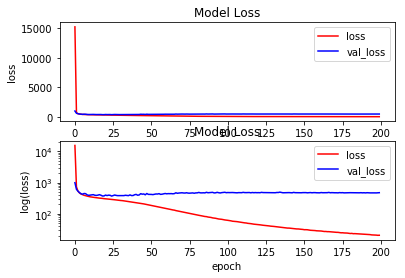

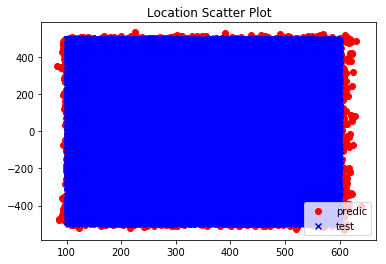

In [84]:
#plot the loss data
import math
plt.subplot(211)
plt.plot(history.history['loss'],'r',label = 'loss')
plt.plot(history.history['val_loss'],'b', label = 'val_loss')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(212)
plt.semilogy(history.history['loss'],'r',label = 'loss')
plt.semilogy(history.history['val_loss'],'b', label = 'val_loss')
plt.title('Model Loss')
plt.ylabel('log(loss)')
plt.xlabel('epoch')
plt.legend()

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_title('Location Scatter Plot')
ax1.scatter(loc_prediction[:,0],loc_prediction[:,1],c = 'r',marker = 'o', label = 'predic')
ax1.scatter(location_test[:,0],location_test[:,1],c = 'b',marker = 'x', label = 'test')
plt.legend()
plt.show()

In [85]:
#The training result
loss = model.evaluate(impulses_test, location_test, verbose=1)
print ('Test loss & mean_absolute_error: ', loss)

40000/40000 [==============================] - 9s 218us/step
Test loss & mean_absolute_error:  [466.8385530029297, 14.885811031341552]


error distance is  22.618215382007627
max error distance is  161.205261443807
min error distance is  0.01025591692542419


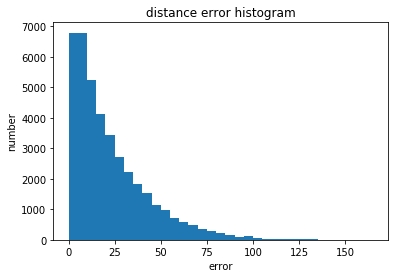

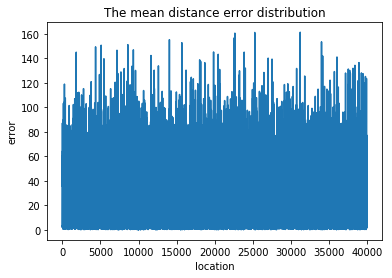

In [86]:
#calculate the mean of error distance
err = loc_prediction - location_test
x = err[:,:1]
y = err[:,1:]

err_abs = np.abs(err)
# err_abs_mean = np.mean(err_abs)
# print(err_abs_mean)
#print(err_abs_mean.shape)
err_dis = np.sqrt(np.square(x)+np.square(y))
err_min = np.min(err_dis)
err_max = np.max(err_dis)
err_avg = np.mean(err_dis)
print("error distance is ", err_avg)
print("max error distance is ", err_max)
print("min error distance is ", err_min)
#set the value of x, y, z
x,y,z = location_test[:,:1],location_test[:,1:2],err_dis

#plot the 2D image of error
plt.figure(1)
#plt.subplot(2,1,2)
plt.hist(err_dis, bins = range(0,170,5)) 
plt.xlabel("error")
plt.ylabel("number")
plt.title("distance error histogram") 

plt.figure(2)
#plt.subplot(2,1,1)
plt.plot(err_dis)
plt.title("The mean distance error distribution")
plt.xlabel("location")
plt.ylabel("error")
plt.show()


Text(0.5, 0.92, 'The mean distance error of 3D Iamge')

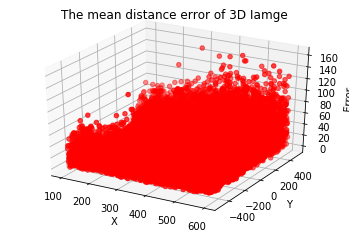

In [87]:
#plot 3D image
ax = plt.subplot(111,projection='3d')
ax.scatter(x,y,z,c='r')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Error")
plt.title("The mean distance error of 3D Iamge")

Text(0.5, 1.0, "The mean distance error of 'heat map'")

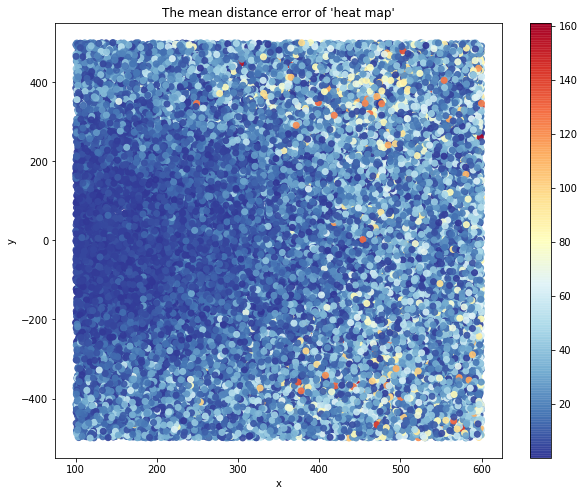

In [143]:
#draw the "heatmap" of error
fig = plt.figure(figsize=(10,8))
ax3 = fig.add_subplot(111)
cm = plt.cm.get_cmap('RdYlBu_r') #Accent  RdYlBu_r RdYlBu  Blues_r  Greens  YlOrBr_r

sc = ax3.scatter(x,y,c = z, marker = 'o', label = 'test',alpha=0.9, cmap=cm)
plt.colorbar(sc)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
plt.title("The mean distance error of 'heat map'")

the mean of error 6.689543
the max of error 49.156607
the max of error 0.078278


Text(0.5, 1.0, "The mean distance error of 'heat map'")

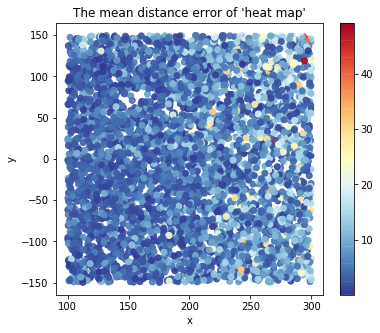

In [154]:
err_map = np.hstack((location_test, err_dis))
err_map = pd.DataFrame(err_map, columns=['x', 'y', 'err'])
err_map_300 = err_map[err_map['x']<300]
err_map_300 = err_map_300[err_map_300['y']<150]
err_map_300 = err_map_300[err_map_300['y']>-150]
# np.array(err_map_300['x'])
print('the mean of error %f'% err_map_300['err'].mean())
print('the max of error %f'% err_map_300['err'].max())
print('the max of error %f'% err_map_300['err'].min())

fig = plt.figure(figsize=(6,5))
ax4 = fig.add_subplot(111)
cm = plt.cm.get_cmap('RdYlBu_r') #Accent  RdYlBu_r RdYlBu  Blues_r  Greens  YlOrBr_r
sc = ax4.scatter(np.array(err_map_300['x']),np.array(err_map_300['y']),c = np.array(err_map_300['err']), marker = 'o', label = 'test',alpha=0.9, cmap=cm)
plt.colorbar(sc)
ax4.set_xlabel("x")
ax4.set_ylabel("y")
plt.title("The mean distance error of 'heat map'")

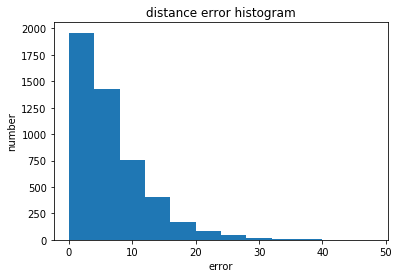

In [151]:
#plot the 2D image of error
fig = plt.figure()
ax5 = fig.add_subplot(111) 
plt.hist(np.array(err_map_300['err']), bins=range(0,50,4))
plt.xlabel("error")
plt.ylabel("number")
plt.title("distance error histogram") 
plt.show()